In [39]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector


db = mysql.connector.connect(
    host='localhost',
    user='root',
    password='manager',
    database='ecommerce'
)
cur = db.cursor()





# list all unique cities where customers are located.




In [41]:
query = "select distinct customer_city from customers"

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


 # Count the number of orders placed in 2017

In [43]:
query = " select count(order_id )from orders where year(order_purchase_timestamp) = 2017 "

cur.execute(query)

data = cur.fetchall()

data

"total orders placed in 2017 are", data[0][0]

('total orders placed in 2017 are', 180404)

# Find the total sales per category.

In [45]:

query = "select upper(products.product_category)category,round(sum(payments.payment_value),2) sales from products join order_items on products.product_id = order_items.product_id join payments on payments.order_id = order_items.order_id group by category"

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["category","sales"])
df

,category,sales
0,SPORT LEISURE,5568510.24
1,HOME APPLIANCES,382129.08
2,FURNITURE OFFICE,2587305.95
3,COOL STUFF,3118792.00
4,BED TABLE BATH,6850214.68
...,...,...
69,PARTY ARTICLES,23865.24
70,LA CUISINE,11654.12
71,FASHION CHILDREN'S CLOTHING,3142.68
72,INSURANCE AND SERVICES,1298.04


# calculate the percentage of orders that were paid in installments

In [47]:
query = "select (sum(case when payment_installments >= 1 then 1 else 0 end))/count(*)*100 from payments"

cur.execute(query)

data = cur.fetchall()
"the percentage of orders that were paid in installments is", data[0][0]

('the percentage of orders that were paid in installments is',
 Decimal('99.9981'))

# Count the number of customers from each state. 

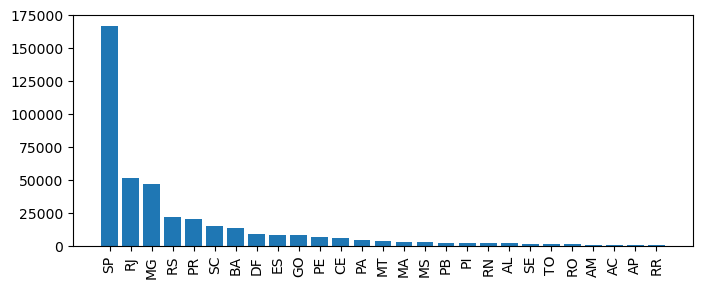

In [49]:
query = "select customer_state ,count(customer_id) from customers group by customer_state"

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["state","customer_count"])
df = df.sort_values(by = "customer_count",ascending = False)

plt.figure(figsize = (8,3))
plt.bar(df["state"], df["customer_count"])
plt.xticks(rotation = 90)
plt.show()

# Calculate the number orders per month in 2018

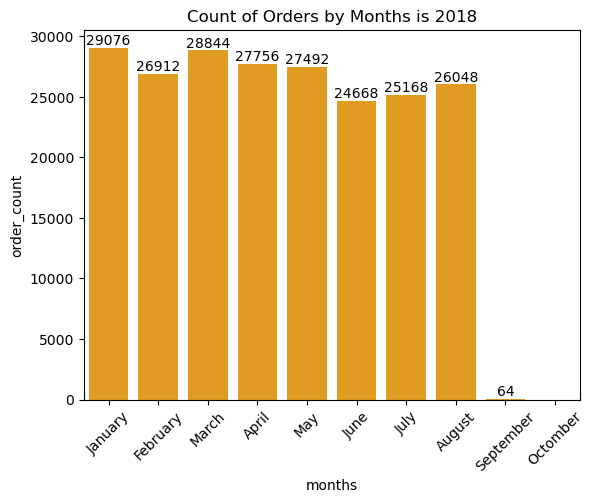

In [51]:
query = "select monthname(order_purchase_timestamp) months,count(order_id) order_count from orders where year(order_purchase_timestamp) = 2018 group by months"

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data,columns = ["months","order_count"])
o = ["January","February","March","April","May","June","July","August","September","Octomber"]

ax = sns.barplot(x = df["months"],y = df["order_count"],data = df,order = o,color = "orange")
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("Count of Orders by Months is 2018")
plt.show()


# Find the average number of products per order, grouped by customer city

In [53]:
query = """ with count_per_order as (select orders.order_id, orders.customer_id, count(order_items.order_id)as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id,orders.customer_id)

select customers.customer_city,round(avg(count_per_order.oc),2)average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders desc
"""
cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data,columns = ["customer city","average orders"])
df.head(10)

,customer city,average orders
0,padre carvalho,28.00
1,celso ramos,26.00
2,datas,24.00
3,candido godoi,24.00
4,matias olimpio,20.00
5,cidelandia,16.00
6,curralinho,16.00
7,picarra,16.00
8,morro de sao paulo,16.00
9,teixeira soares,16.00


# Calculate the percentage of total revenue contributed by each product category

In [55]:
query =  """ select upper(products.product_category)category,
round((sum(payments.payment_value)/(select sum(payment_value)from payments))*100,2)sales_percentage
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category order by sales_percentage desc"""


cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data,columns = ["category","percentage distribution"])
df.head(10)

,category,percentage distribution
0,BED TABLE BATH,42.79
1,HEALTH BEAUTY,41.41
2,COMPUTER ACCESSORIES,39.61
3,FURNITURE DECORATION,35.73
4,WATCHES PRESENT,35.71
5,SPORT LEISURE,34.78
6,HOUSEWARES,27.35
7,AUTOMOTIVE,21.30
8,GARDEN TOOLS,20.95
9,COOL STUFF,19.48


# Identify the correlation between product price and the number of times a product has been purchased.

In [57]:
import numpy as np
query = """select products.product_category,
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["category","order_count","price"])
arr1 = df["order_count"]
arr2 = df["price"]
a = np.corrcoef(arr1,arr2)
print("the correction between price and number of times a product has been purchase is",a[0][1])

the correction between price and number of times a product has been purchase is -0.10631514167157564


 # Calculate the total revenue generated by each seller, and rank them by revenue 

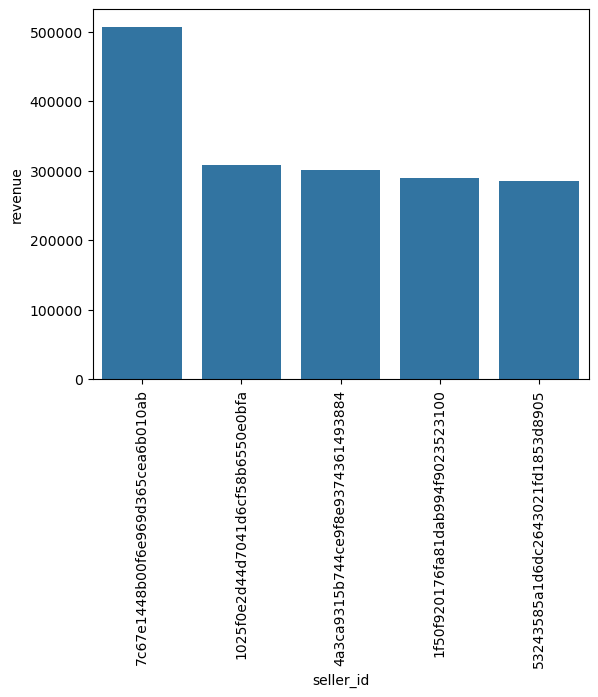

In [59]:
query = """select *,dense_rank() over(order by revenue desc)as rn from
(select order_items.seller_id, sum(payments.payment_value)
revenue from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns =["seller_id","revenue","rank"] )
df = df.head()
sns.barplot(x = "seller_id",y = "revenue", data = df)
plt.xticks(rotation = 90)
plt.show()


# Calculate the moving average of order values for each customer over their order history.

In [61]:
query = """ select customer_id, order_purchase_timestamp,payment,
avg(payment)over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row)as mov_avg
from 
(select orders.customer_id, orders.order_purchase_timestamp,
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a
"""
cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
...,...,...,...,...
415539,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000
415540,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
415541,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
415542,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


# Calculate the cumulative sales per month for each year

In [63]:
query = """select years,months,payment,sum(payment)
over(order by years,months)cumulative_sales from
(select year(orders.order_purchase_timestamp)as years,
month(orders.order_purchase_timestamp)as months,
round(sum(payments.payment_value),2)as payment from orders join payments
on orders.order_id = payments.order_id
group by years,months order by years,months)as a
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data)
df



,0,1,2,3
0,2016,9,1008.96,1008.96
1,2016,10,236361.92,237370.88
2,2016,12,78.48,237449.36
3,2017,1,553952.16,791401.52
4,2017,2,1167632.04,1959033.56
5,2017,3,1799454.40,3758487.96
6,2017,4,1671152.12,5429640.08
7,2017,5,2371675.28,7801315.36
8,2017,6,2045105.52,9846420.88
9,2017,7,2369531.68,12215952.56


#  Calculate the year-over-year growth rate of total sales

In [65]:
query = """ with a as(select year(orders.order_purchase_timestamp)as years,
round(sum(payments.payment_value),2)as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years,((payment - lag(payment,1) over(order by years))/ 
lag (payment,1)over(order by years) ) * 100 from a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["years","yoy % growth"])
df

,years,yoy % growth
0,2016,NaN
1,2017,12112.703757
2,2018,20.000924


#  calculate the retention rate of customers,defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [67]:
query = """with a as (select customers.customer_id,
min(orders.order_purchase_timestamp)first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id,count(distinct orders.order_purchase_timestamp)next_order
from a join orders
on orders.customer_id = a. customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
group by a.customer_id)

select 100 * (count(distinct a.customer_id)/count(distinct b.customer_id))
from a left join b
on a.customer_id = b.customer_id
"""
cur.execute(query)
data = cur.fetchall()
data


[(None,)]

# identify the top 3 customers who spent the most money in each year.

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'a9dc96b027d1252bbac0a9b72d837fc6'),
  Text(1, 0, '1d34ed25963d5aae4cf3d7f3a4cda173'),
  Text(2, 0, '4a06381959b6670756de02e07b83815f'),
  Text(3, 0, '1617b1357756262bfa56ab541c47bc16'),
  Text(4, 0, 'c6e2731c5b391845f6800c97401a43a9'),
  Text(5, 0, '3fd6777bbce08a352fddd04e4a7cc8f6'),
  Text(6, 0, 'ec5b2ba62e574342386871631fafd3fc'),
  Text(7, 0, 'f48d464a0baaea338cb25f816991ab1f'),
  Text(8, 0, 'e0a2412720e9ea4f26c1ac985f6a7358')])

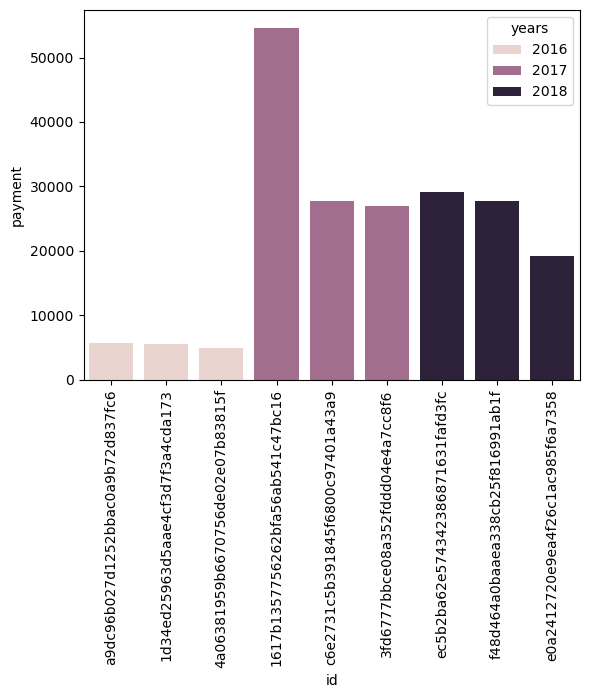

In [69]:
query = """ select years, customer_id,payment,d_rank
from
(select year(orders.order_purchase_timestamp)years,
orders.customer_id,
sum(payments.payment_value)payment,
dense_rank() over (partition by  year(orders.order_purchase_timestamp)
order by sum(payments.payment_value)desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by  year(orders.order_purchase_timestamp),
orders.customer_id)as a
where d_rank <= 3;
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["years","id","payment","rank"])
sns.barplot(x = "id", y = "payment",data = df,hue = "years")
plt.xticks(rotation = 90)